In [2]:
import numpy as np
import pandas as pd

def parse_coords(coords):
    return [float(x) for x in coords.split('-')]

def get_x(filename):
    x_pd = pd.read_csv(filename, header=None)
    x_pd_parsed = x_pd.applymap(parse_coords)
    x_np = x_pd_parsed.to_numpy()
    return np.array([[x for x in y] for y in x_np[:]])

def get_y(filename):
    x_pd = pd.read_csv(filename, header=None)
    return x_pd.to_numpy()

In [3]:
X = get_x('data/train_x.csv')
y = get_y('data/train_y.csv').reshape((-1))

X_test = get_x('data/test_x.csv')
y_test = get_y('data/test_y.csv').reshape((-1))

In [4]:
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches




def plot_path(verts, ax):
    ax.axis('off')
    
    xs, ys = zip(*verts)
    ax.plot(xs, ys, 'x--', lw=2, color='black', ms=10)

    i=0
    for x,y in verts:
        rand_x,rand_y = np.random.rand(2)-0.5
        ax.text(x+rand_x, y+rand_y, 'P'+str(i))
        i += 1

    min_x,max_x = np.min(verts[:,0]),np.max(verts[:,0])
    min_y,max_y = np.min(verts[:,1]),np.max(verts[:,1])


    ax.set_xlim(min_x - 1, max_x + 1)
    ax.set_ylim(min_y - 1, max_y + 1)
    
def plot_many(samples, labels=None):
    n = (samples.shape[0])
    if n < 20 :
        cols = 5
        rows = int((n+4)/5)
        fig = plt.figure(figsize=(cols * 4, rows * 4))
    else :
        cols = 8
        rows = int((n+cols-1)/cols)
        fig = plt.figure(figsize=(cols * 3, rows * 3))
    
    for i in range(n):
        sub = fig.add_subplot(rows, cols, i + 1)
        if labels is not None :
            sub.title.set_text('y={0}'.format(labels[i]))
        else :
            sub.title.set_text('nolabel')
        plot_path(samples[i], sub)

n = 10
plot_many(X[:n], y[:n])

In [100]:
import torch.nn as nn
import torch
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Net, self).__init__()
        self.hidden_dim = hidden_dim

#         self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(input_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, output_dim)

    def forward(self, sentence):
        hidden = self.initHidden()
        print(sentence.shape)
        print()
        lstm_out, _ = self.lstm(sentence, hidden)
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores[-1]

    
    
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sentence):
        hidden = self.initHidden()
        for i in range(len(sentence)):
            out, hidden = self.fwd(sentence[i], hidden)
        return out
        
    def fwd(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
n_letters = 2
n_categories = 4

model = RNN(n_letters, n_hidden, n_categories)    

In [101]:
from torchvision.transforms.functional import to_tensor


Xt = to_tensor(X).float().permute(1,2,0)
inp = Xt[0].view(len(Xt[0]), 1, -1)
print(inp.shape)
output = model(inp)
yt = torch.zeros(y.shape[0],4)
for i,idx in enumerate(y):
    yt[i,idx] = 1
yt[:5]
print(output)

torch.Size([5, 1, 2])
tensor([[-0.5096, -0.2206, -0.0390,  0.4322]], grad_fn=<AddmmBackward>)


In [102]:
import torch.optim as optim

learning_rate =5e-5

loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

X_test_tens = to_tensor(X_test).float().permute(1,2,0)

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    return top_i[0].item()

def accuracy(testX, testY):
    with torch.no_grad() :
        sum_ok = 0
    # Go through a bunch of examples and record which are correctly guessed
        for i in range(testX.shape[0]):
            category = testY[i]
            line = testX[i].reshape(-1)
            category_tensor = torch.tensor([testY[i]], dtype=torch.long)
            line_tensor = testX[i].reshape(testX[i].shape[0],1,testX[i].shape[1])

            output = model(line_tensor)
            guess = categoryFromOutput(output)
            if guess == category :
                sum_ok += 1

        acc = sum_ok/testX.shape[0]
        print('acc:', acc)
        return acc

# See what the scores are before training
# Note that element i,j of the output is the score for tag j for word i.
# Here we don't need to train, so the code is wrapped in torch.no_grad()
with torch.no_grad():
    row = Xt[0]
    sentence_in = row.view(len(row), 1, -1)
    tag_scores = model(sentence_in)
    print(tag_scores)

loss_log = []
acc_log = []
t_acc_log = []

accuracy(X_test_tens, y_test)

tensor([[-0.5096, -0.2206, -0.0390,  0.4322]])
acc: 0.24


0.24

In [103]:
loss_single = 0

for epoch in range(10):  # again, normally you would NOT do 300 epochs, it is toy data
    acc_loss = 0
    
    for i in range(len(Xt)) :
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        row = Xt[i]
        sentence_in = row.view(len(row), 1, -1)
        targets = torch.tensor([y[i]], dtype=torch.long)
        
        # Step 3. Run our forward pass.
        tag_scores = model(sentence_in)
        tag_scores = tag_scores.view(1,-1)

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(tag_scores, targets)
        loss_single+=(loss.item())
        acc_loss += loss.item()
#         print(loss)
        loss.backward()
    
        for p in model.parameters():
            p.data.add_(p.grad.data, alpha=-learning_rate)
    
        if i > 0 and i % 1000 == 0 :
#             print('loss', loss_single)
            loss_single=0
    
    loss_log.append(acc_loss)
    print("epoch", epoch, "loss", acc_loss)
    acc_log.append(accuracy(Xt, y))
    t_acc_log.append(accuracy(X_test_tens, y_test))
print('DONE')

epoch 0 loss nan


KeyboardInterrupt: 

In [ ]:
# See what the scores are after training
with torch.no_grad():
    row = Xt[0]
    sentence_in = row.view(len(row), 1, -1)
    tag_scores = model(sentence_in)
    print(tag_scores)

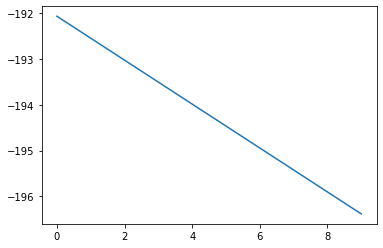

In [41]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(loss_log)

In [ ]:
plt.figure()
plt.plot(acc_log)
plt.plot(t_acc_log)

In [40]:


accuracy(Xt, y)

acc: 0.6463333333333333


0.6463333333333333

In [46]:
accuracy(Xt, y)

acc: 0.6461111111111111


0.6461111111111111

In [47]:
X_test_tens = to_tensor(X_test).float().permute(1,2,0)
accuracy(X_test_tens, y_test)

acc: 0.637


0.637